In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")

url_1 = 'TrainingWiDS2021.csv'
url_2 = 'UnlabeledWiDS2021.csv'

In [22]:
# Splitted data to make same shape of both test and train so that we can apply pre processing on both
# Ref : https://www.kaggle.com/siavrez/2020fatures
train_df = pd.read_csv(url_1, error_bad_lines=False)
test_df  = pd.read_csv(url_2, error_bad_lines=False)
target='diabetes_mellitus'
y = train_df["diabetes_mellitus"]
train_df.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [23]:
# Remove features which has more than 50% percentage of missing values
# Return reduced dataset

def drop_NaN_Values(df, threshold):
    NaN_cols = []
    for col in df.columns:
        NaN_ratio = df[col].isnull().sum() / df.shape[0]
        if NaN_ratio >= threshold:
            NaN_cols.append(col)
    df = df.drop(NaN_cols, axis=1)
    return df,NaN_cols

train_df_reduced,NaN_columns = drop_NaN_Values(train_df.copy(), 0.5)
train_df_reduced.drop(['readmission_status','Unnamed: 0','encounter_id','hospital_id','icu_id'], axis=1,inplace=True)
train_df_reduced.shape


(130157, 103)

Imputing:

In [24]:
# we can apply random sample imputation in Ethnicity,icu_admit_source and hospital_admit_source to maintain the distribution
#categorical_features = [feature for feature in train_df_reduced.columns if train_df_reduced[feature].dtype == 'O']
def impute_random(df, col):
    random_sample = df[col].dropna().sample(df[col].isnull().sum(), random_state=0)
    random_sample.index = df[df[col].isnull()].index
    df.loc[df[col].isnull(), col] = random_sample
    
impute_random(train_df_reduced, 'ethnicity')
impute_random(train_df_reduced, 'icu_admit_source') 
impute_random(train_df_reduced, 'hospital_admit_source')

train_df_reduced["age"] = np.where(train_df_reduced[target] == 1, train_df_reduced["age"].fillna(66), train_df_reduced["age"].fillna(63))
train_df_reduced['gender'].fillna(train_df_reduced['gender'].mode()[0], inplace=True)

#impute bmi
def fill_bmi(df):
    df['bmi'] = np.where(df['bmi'].isnull(), df['weight']/ (df['height']/100)**2, df['bmi'])   
    
fill_bmi(train_df_reduced)

#impute height with 170 as mean and median both
train_df_reduced["height"] = train_df_reduced["height"].fillna(170)

# impute weight wrt target
train_df_reduced["weight"] = np.where(train_df_reduced[target] == 1, train_df_reduced["weight"].fillna(91), train_df_reduced["weight"].fillna(82))
train_df_reduced['gcs_unable_apache'].fillna(train_df_reduced['gcs_unable_apache'].median(), inplace=True)

#train_df_reduced['bmi'] = train_df_reduced['bmi'].fillna(train_df_reduced['bmi'].mean())
train_df_reduced.shape

(130157, 103)

In [25]:
print(f'Percent of Nans: {round(train_df_reduced.copy().isna().sum().sum()/len(train_df_reduced.copy()), 2)}')

Percent of Nans: 6.04


In [26]:
categorical_features = [feature for feature in train_df_reduced.columns if train_df_reduced[feature].dtype == 'O']
numerical_features = [feature for feature in train_df_reduced.columns if train_df_reduced[feature].dtype != 'O']
binary_features = [feature for feature in numerical_features if train_df_reduced[feature].nunique() == 2]
cont_features = [feature for feature in numerical_features if feature not in binary_features]

In [27]:
# Working on Continuous features. Creating a copy of main DS to work on it seperately.

max_min_df = train_df_reduced[cont_features].copy()

max_min_features = [feature for feature in cont_features if 'max' in feature or 'min' in feature and feature not in "albumin_apache"]
print("total features: ",len(max_min_features))


#separate out the max and min features
max_features = [feature for feature in max_min_features if "max" in feature]
min_features = [feature for feature in max_min_features if "min" in feature]
print("max: ",len(max_features))
print("min: ",len(min_features))

# take the average and add them to the data.
for i in range(0,len(max_features)):
    col = "_".join(min_features[i].split("_")[:-1]) + "_avg"
    avg = (max_min_df[min_features[i]] +  max_min_df[max_features[i]]) / 2
    max_min_df[col] = avg

# we got our average features, now remove the max and min features from data
max_min_df.drop(max_features, axis=1, inplace=True)
max_min_df.drop(min_features, axis=1, inplace=True)

# we have reduce a 31 features, which is better then PCA too.
max_min_df.shape

avg_features = [feature for feature in max_min_df.columns if 'avg' in feature]
print(len(avg_features))


#let's see the percentage of missing values, if % will be less ten 30 then we will impute it.
miss_nan = max_min_df[avg_features].isnull().sum() / len(max_min_df) * 100
miss_nan.sort_values(ascending=False).to_frame().head(10)

#drop the feature which are having missing greater then 30%
great_30 = miss_nan[miss_nan[:] > 30].index
max_min_df.drop(great_30, axis=1, inplace=True)

less_30 = miss_nan[miss_nan[:] < 30].index
# as we have taken the avg, so just fill it with mean now.
for col in less_30:
    max_min_df[col] = max_min_df[col].fillna(max_min_df[col].mean())

total features:  62
max:  31
min:  31
31


Imputing numerical features

In [28]:
#Working on Numerarical features other than the min max features
other_nan_col = [feature for feature in max_min_df.columns if "avg" not in feature]
print("total other features then AVG: ", len(other_nan_col))

for col in other_nan_col:
    max_min_df[col] = max_min_df[col].fillna(max_min_df[col].mean())

#check if any null values remaining
#max_min_df.isnull().sum().sum()

train_df_reduced.shape

total other features then AVG:  21


(130157, 103)

Concat the mydata back to training data and proceed further

In [29]:
#first we have to free all the cont features from cont then concat it
train_df_reduced.drop(cont_features,axis=1, inplace=True)

# concat max_min_df to train
train_df_reduced = pd.concat([train_df_reduced, max_min_df], axis=1)

In [30]:
train_df_reduced.shape

(130157, 72)

In [31]:
#Working on Categorical features

train_df_reduced['gender'] = train_df_reduced['gender'].map({'M':0,'F':1})

# let's encode the feature using Integer label encoding
# we will use value_counts to know, how it is encoded, you can also use unique()
cat_cols = ['ethnicity', 'hospital_admit_source','icu_admit_source','icu_stay_type','icu_type']
for col in cat_cols:
    map_dict = {k: i for i, k in enumerate(train_df_reduced[col].value_counts().index, 0)}
    train_df_reduced[col] = train_df_reduced[col].map(map_dict)

train_df_reduced[categorical_features].head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,0,0,2,2,0,7
1,0,1,2,2,0,0


In [32]:
print(f'Percent of Nans: {round(train_df_reduced.copy().isna().sum().sum()/len(train_df_reduced.copy()), 2)}')

Percent of Nans: 0.0


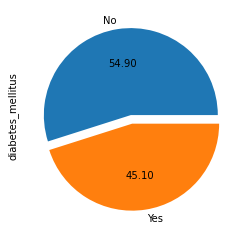

In [74]:
# from sklearn.utils import resample

# #The dataset is skewed towards class 0, so,balace the dataset.
# df_majority = train_df_reduced[train_df_reduced['diabetes_mellitus']==0]
# df_minority = train_df_reduced[train_df_reduced['diabetes_mellitus']==1]

# # Upsampling
# df_minority_upsampled = resample(df_minority,
#                                  replace=True,       # sample with replacement
#                                  n_samples=83798,    # to match majority class
#                                  random_state= 303)  # reproducible results
 
# # Combine majority class with upsampled minority class
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# # Display new class counts
# df_upsampled.diabetes_mellitus.value_counts()
# df_upsampled[target].value_counts().plot(kind="pie", explode=[0,0.1], autopct="%.2f", labels=["No","Yes"])
# plt.show()

In [75]:
# df_upsampled

,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_post_operative,arf_apache,gcs_unable_apache,...,d1_calcium_avg,d1_creatinine_avg,d1_glucose_avg,d1_hco3_avg,d1_hemaglobin_avg,d1_hematocrit_avg,d1_platelets_avg,d1_potassium_avg,d1_sodium_avg,d1_wbc_avg
2,0,0,1,0,0,0,0,0,0,0.0,...,8.272228,1.428663,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912
3,1,0,1,1,1,0,7,1,0,0.0,...,8.272228,1.428663,136.500000,23.822608,10.250000,29.950000,120.500000,4.250000,138.42086,8.50000
4,0,0,0,0,0,0,0,0,0,0.0,...,8.272228,1.428663,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912
7,0,0,0,0,0,0,0,0,0,0.0,...,7.800000,2.050000,129.000000,29.000000,7.800000,25.500000,260.000000,4.100000,140.00000,12.80000
8,0,0,0,5,3,0,1,0,0,0.0,...,7.300000,1.160000,326.500000,23.000000,12.300000,37.900000,226.000000,5.200000,142.00000,24.70000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40538,0,1,1,2,0,0,4,0,0,0.0,...,8.272228,1.428663,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912
59679,0,0,1,3,0,0,2,0,0,0.0,...,8.700000,1.830000,136.000000,20.000000,13.400000,41.200000,267.500000,4.600000,135.00000,21.09500
31657,0,0,1,2,2,0,0,0,0,0.0,...,8.400000,2.450000,249.000000,23.000000,10.500000,34.500000,152.000000,4.600000,133.00000,15.30000
57773,0,0,0,3,0,0,2,0,0,0.0,...,8.900000,0.790000,278.000000,26.000000,12.800000,38.400000,207.000000,3.900000,135.00000,8.39000


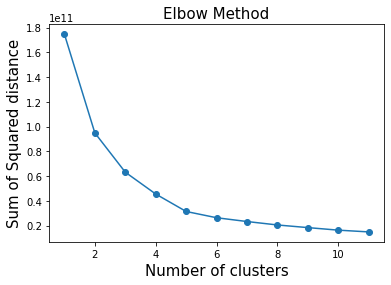

In [35]:
# plot elbow curve
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

#drop country column
data=train_df_reduced.drop(['ethnicity'],axis=1)

#scaling data
scaling=StandardScaler()
scaled=scaling.fit_transform(data)

scaled_df=pd.DataFrame(scaled,columns=data.columns)

# princt scaled dataset
scaled_df.head()

a=[]
K=range(1,12)
for i in K:
    kmean=KMeans(n_clusters=i)
    kmean.fit(data)
    a.append(kmean.inertia_)
    
plt.plot(K,a,marker='o')
plt.title('Elbow Method',fontsize=15)
plt.xlabel('Number of clusters',fontsize=15)
plt.ylabel('Sum of Squared distance',fontsize=15)
plt.show()

In [36]:
#chosing no. of clusters as 4 and refitting kmeans model
kmeans = KMeans(n_clusters = 4,random_state = 111)
kmeans.fit(scaled_df)

KMeans(n_clusters=4, random_state=111)

In [37]:
#count number of records in every cluster
pd.Series(kmeans.labels_).value_counts()

0    51611
1    39841
3    23751
2    14954
dtype: int64

In [79]:
# #calculate how good our model is
# #calculate Silhouette Coefficient for K=4
# from sklearn import metrics

# metrics.silhouette_score(scaled_df, kmeans.labels_)

0.06670797943091242

In [38]:
#predicting values
cluster_labels = kmeans.fit_predict(scaled_df)

preds = kmeans.labels_
kmeans_df = pd.DataFrame(train_df_reduced)
kmeans_df['KMeans_Cluster'] = preds
kmeans_df.head(10)

,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_post_operative,arf_apache,gcs_unable_apache,...,d1_creatinine_avg,d1_glucose_avg,d1_hco3_avg,d1_hemaglobin_avg,d1_hematocrit_avg,d1_platelets_avg,d1_potassium_avg,d1_sodium_avg,d1_wbc_avg,KMeans_Cluster
0,0,0,0,2,2,0,7,0,0,0.0,...,2.370000,138.500000,17.000000,8.900000,27.400000,233.000000,3.700000,135.00000,14.10000,0
1,0,0,1,2,2,0,0,0,0,0.0,...,0.635000,136.500000,26.500000,11.200000,36.500000,522.000000,4.000000,145.00000,18.00000,0
2,0,0,1,0,0,0,0,0,0,0.0,...,1.428663,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912,0
3,1,0,1,1,1,0,7,1,0,0.0,...,1.428663,136.500000,23.822608,10.250000,29.950000,120.500000,4.250000,138.42086,8.50000,3
4,0,0,0,0,0,0,0,0,0,0.0,...,1.428663,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912,1
5,0,0,0,3,0,0,0,0,0,0.0,...,0.710000,140.500000,27.000000,15.600000,44.200000,159.000000,3.800000,137.00000,10.90000,1
6,0,0,1,1,0,0,0,0,0,0.0,...,0.815000,163.000000,31.500000,11.300000,35.500000,286.500000,4.600000,135.50000,7.60000,1
7,0,0,0,0,0,0,0,0,0,0.0,...,2.050000,129.000000,29.000000,7.800000,25.500000,260.000000,4.100000,140.00000,12.80000,0
8,0,0,0,5,3,0,1,0,0,0.0,...,1.160000,326.500000,23.000000,12.300000,37.900000,226.000000,5.200000,142.00000,24.70000,0
9,0,0,0,3,0,0,1,0,0,0.0,...,0.830000,134.000000,28.000000,12.800000,37.200000,232.000000,3.700000,139.00000,12.80000,0


In [39]:
#source https://www.omnicalculator.com/health/risk-dm
train_df_reduced['diabete_risk'] = 100 / (1 + np.exp(-1*(0.028*train_df_reduced['age'].values + 0.661*np.where(train_df_reduced['gender'].values=="M", 1, 0) +
                                   0.412 * np.where(train_df_reduced['ethnicity'].values=="Native American", 0, 1) +
                                   0.079 * train_df_reduced['glucose_apache'].values + 0.018 * train_df_reduced['d1_diasbp_avg'].values +
                                   0.07 * train_df_reduced['bmi'].values + 0.481 * train_df_reduced['cirrhosis'].values - 13.415)))
    


In [40]:
train_df_reduced

,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_post_operative,arf_apache,gcs_unable_apache,...,d1_glucose_avg,d1_hco3_avg,d1_hemaglobin_avg,d1_hematocrit_avg,d1_platelets_avg,d1_potassium_avg,d1_sodium_avg,d1_wbc_avg,KMeans_Cluster,diabete_risk
0,0,0,0,2,2,0,7,0,0,0.0,...,138.500000,17.000000,8.900000,27.400000,233.000000,3.700000,135.00000,14.10000,0,99.106936
1,0,0,1,2,2,0,0,0,0,0.0,...,136.500000,26.500000,11.200000,36.500000,522.000000,4.000000,145.00000,18.00000,0,97.495046
2,0,0,1,0,0,0,0,0,0,0.0,...,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912,0,97.830764
3,1,0,1,1,1,0,7,1,0,0.0,...,136.500000,23.822608,10.250000,29.950000,120.500000,4.250000,138.42086,8.50000,3,99.811979
4,0,0,0,0,0,0,0,0,0,0.0,...,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912,1,97.396390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,0,0,0,0,0,0,4,0,0,0.0,...,144.295056,23.822608,11.180651,33.747567,200.404226,4.091154,138.42086,11.91912,1,99.145883
130153,0,0,1,3,0,0,2,0,0,0.0,...,139.000000,27.000000,13.500000,39.000000,130.000000,3.600000,140.00000,9.95000,1,97.600777
130154,0,1,0,0,0,0,4,0,0,0.0,...,200.500000,22.500000,10.600000,32.000000,214.500000,3.750000,140.50000,31.10000,2,100.000000
130155,0,0,0,0,0,0,0,0,0,0.0,...,146.500000,20.000000,9.100000,28.000000,183.000000,5.700000,141.00000,15.30000,0,94.846582


In [41]:

y = kmeans_df["diabetes_mellitus"]
del kmeans_df['diabetes_mellitus']
from sklearn.model_selection import train_test_split

# Train and test split
prep_df = kmeans_df.copy().select_dtypes(include=np.number)

X_train, X_val, y_train, y_val = train_test_split(prep_df,y, test_size=0.20, random_state= 20, shuffle=True )

In [82]:
# y.shape

(185804,)

In [42]:
!pip install lightgbm
import lightgbm as lgb
from lightgbm import *
from sklearn import metrics

# LGBM classifier with score

classifier = LGBMClassifier(n_estimators= 690, max_depth= 4)
classifier.fit(X_train, y_train)
print('\n\n')
classifier.score(X_val, y_val)
print('\n\n')
classifier.fit(prep_df, y)
#classifier.fit(train, yy)
result = metrics.roc_auc_score(y.values, classifier.predict(prep_df))

In [43]:
result

0.7469654083826409

In [44]:
X_train, X_val, y_train, y_val = train_test_split(prep_df,y, test_size=0.20, random_state= 20, shuffle=True )

In [45]:
# XGBoost with score
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

data_dmatrix = xgb.DMatrix(data=prep_df,label=y)
#data_dmatrix = xgb.DMatrix(data=train,label=yy)

model = XGBClassifier()
model.fit(X_train, y_train)
xbg_pred = model.predict(X_val)
model.score(X_train,y_train)
model.score(X_val,y_val)

[12:27:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8260986478180701

In [85]:
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csc_matrix

X = csc_matrix(prep_df.values)
y_ = y.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_, stratify=y_, train_size=0.75, random_state=42)

In [86]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score
from sklearn import metrics, model_selection

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'F1-score': make_scorer(f1_score), 'Recall': make_scorer(recall_score), 'Precision': make_scorer(precision_score)}

def grid(estimator, scoring, cv, X, y, verbose):
    return GridSearchCV(
    estimator = estimator,
    param_grid = params,
    scoring = scoring,
    cv = cv,
    verbose = verbose,
    return_train_score = True,
    refit="AUC",
    n_jobs = -3
    ).fit(X, y)

In [87]:
# Random Forest
params = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 4]
  }

estimator = RandomForestClassifier()

rf_grid_search = grid(estimator, scoring, 3, X_train, y_train, 4)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-3)]: Done  86 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-3)]: Done 162 out of 162 | elapsed: 366.9min finished


In [89]:
rf_grid_search.best_estimator_

RandomForestClassifier(max_depth=7, min_samples_split=4, n_estimators=300)

In [91]:
rf_grid_search.best_score_

0.8253909619440369

In [92]:
rf_grid_search.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [46]:
# Train and test split
X_train, X_val, y_train, y_val = train_test_split(prep_df, y, test_size=0.20, random_state= 20, shuffle=True )

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgbr = XGBRegressor()

max_depth = [3,5,10]
n_estimators = [500,600,800]
learning_rate = [0.15,0.3]
params = {
    #Hypeparameter tuning 
    'max_depth':max_depth,
    'n_estimators':n_estimators,
    'learning_rate':learning_rate}
xgbr_random = RandomizedSearchCV(estimator = xgbr, param_distributions = params, n_iter = 4, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgbr_random.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  2.1min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  9.4min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [48]:
xgbr_random.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=600, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
xgbr_random.best_params_

{'n_estimators': 600, 'max_depth': 3, 'learning_rate': 0.15}

In [51]:
# XGboost with tuning hyper parameters
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score

xgb_cls = xgb.XGBClassifier(max_depth = 3, subsample = 1, colsample_bytree = 1, colsample_bylevel = 1,
    scale_pos_weight = 1,min_child_weight = 1,reg_alpha = 0, n_jobs = 8, objective = 'binary:logistic', gamma = 0,
    nthread=20, seed = 27, n_estimators=600)

xgb_cls.fit(X_train,y_train)

y_pred = xgb_cls.predict_proba(X_val)
y_scores=y_pred[:,1]
fpr, tpr, threshhold = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)
average_precision = average_precision_score(y_val, y_scores)
precision, recall, _ = precision_recall_curve(y_val, y_scores)
print(roc_auc)

[12:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8521256512750603


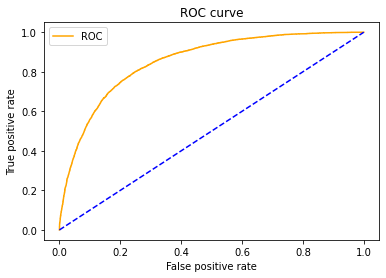




Area under the curve:  0.8521256512750603


In [52]:
def plot_roc_curve(fpr, tpr):
  plt.plot(fpr, tpr, color='orange', label='ROC')
  plt.plot([0,1],[0,1], color = 'blue', linestyle='--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend()
  plt.show()

plot_roc_curve(fpr, tpr) 
print('\n\n')
print('Area under the curve: ', roc_auc_score(y_val, y_scores))

In [53]:
X_train, X_val, y_train, y_val = train_test_split(prep_df,y, test_size=0.20, random_state= 20, shuffle=True )

[12:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.882717887154862
0.8260986478180701
0.8473262173284904


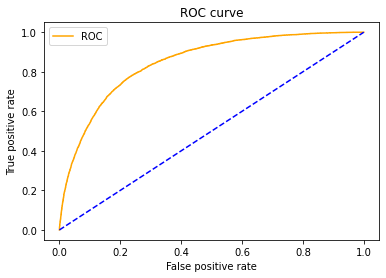




Area under the curve:  0.8473262173284904


In [54]:
# XGBoost without tuning hyper parameters
import xgboost as xgb
from xgboost import XGBClassifier

data_dmatrix = xgb.DMatrix(data=prep_df,label=y)
#data_dmatrix = xgb.DMatrix(data=train,label=yy)

model = XGBClassifier()
model.fit(X_train, y_train)
xbg_pred = model.predict(X_val)
print(model.score(X_train,y_train))
print(model.score(X_val,y_val))

y_pred = model.predict_proba(X_val)
y_scores=y_pred[:,1]
fpr, tpr, threshhold = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)
average_precision = average_precision_score(y_val, y_scores)
precision, recall, _ = precision_recall_curve(y_val, y_scores)
print(roc_auc)
plot_roc_curve(fpr, tpr) 
print('\n\n')
print('Area under the curve: ', roc_auc_score(y_val, y_scores))

Extra--- Working:::

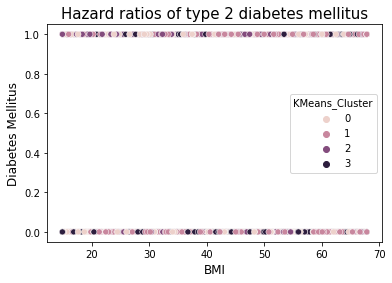

In [38]:
#visualization of clusters Diabetes Mellitus vs BMI

import seaborn as sns

sns.scatterplot(kmeans_df['bmi'],kmeans_df['diabetes_mellitus'],hue='KMeans_Cluster',data=kmeans_df) 
plt.title("Hazard ratios of type 2 diabetes mellitus", fontsize=15)
plt.xlabel("BMI", fontsize=12)
plt.ylabel("Diabetes Mellitus", fontsize=12)
plt.show()

Feature creation: